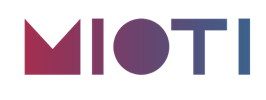
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S6: Reconocimiento facial

## Objetivos

El objetivo de este challenge es evaluar distintos clasificadores sobre un dataset de reconocimiento facial.

## Configuración del entorno

In [1]:
%matplotlib inline

from pylab import *
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [2]:
def print_faces(images, target, top_n):
    '''Dibuja las imágenes de las caras'''
    
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        #p.text(0, 14, str(target[i]), color="red")
        p.text(1, 60, str(i), color="black", size=15)
        p.text(0, 60, str(i), color="yellow", size=15)

## Dataset

Esta vez utilizaremos un dataset de caras para realizar un algoritmo de reconocimiento facial.

In [3]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [4]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [5]:
print(faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



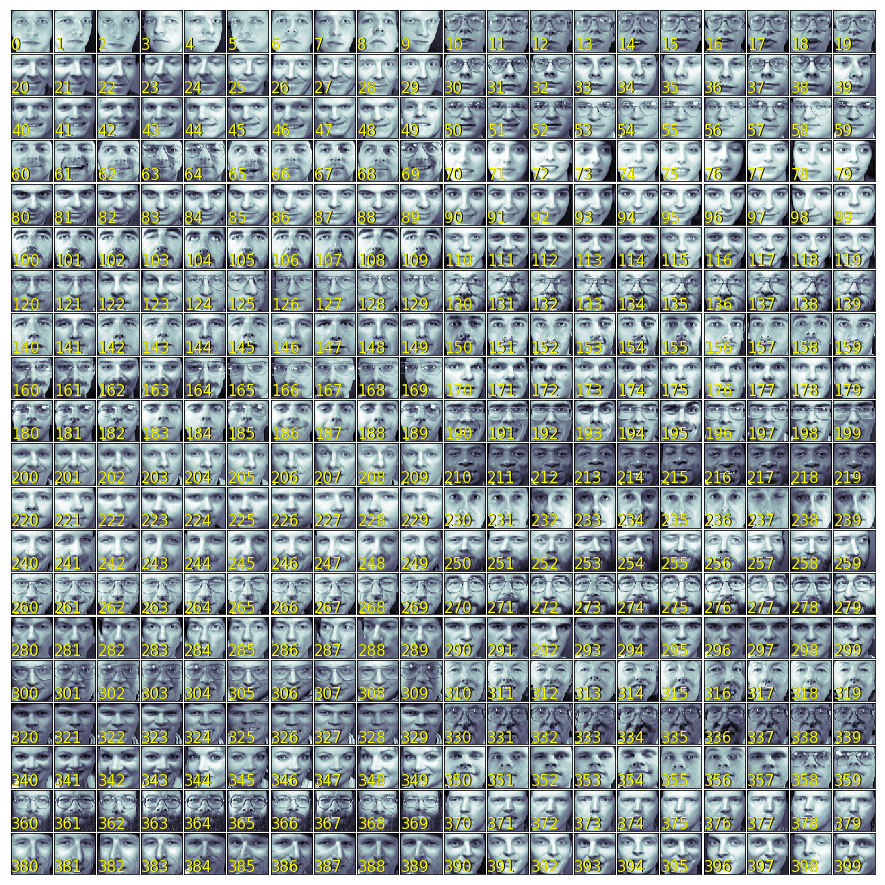

In [6]:
print_faces(faces.images, faces.target, 400)

### Atributos disponibles (X)

Asignamos la variable data a la variable X

In [7]:
dataset_X = faces.data

In [8]:
dataset_X *= 255

In [9]:
dataset_X.shape

(400, 4096)

In [10]:
dataset_X[0]

array([ 79.02893 ,  93.78099 , 106.42561 , ...,  38.987602,  41.095043,
        40.041325], dtype=float32)

### Variable objetivo (y)

En este caso, estamos ante un problema de clasificación, la variable a predecir es la persona a la que pertenece cada fotografía de un conjunto de 40 personas.

In [11]:
dataset_y = faces.target

In [12]:
dataset_y.shape

(400,)

In [13]:
print(dataset_y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

Vamos a simplificar el problema y convertirlo en detectar gente con gafas y gente sin gafas. Como el tamaño del dataset es pequeño (sólo 400 instancias) vamos a reducirlo.

Buscamos a mano la gente con gafas y reclasificamos el vector `y`.

In [14]:
glasses = [(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
           (69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
           (164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
           (194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
           (330, 339), (358, 359), (360, 369)]

In [15]:
transformed_dataset_y = np.zeros(len(dataset_y), dtype=np.int16) 
for g in glasses:
    for i in range(g[0], g[1] + 1):
        transformed_dataset_y[i] = 1
        
print(transformed_dataset_y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
dataset_y = transformed_dataset_y

## Preprocesado de los datos

Examina los datos de entrenamiento y analiza si es necesario realizar algún preprocesamiento sobre los datos. Si es que sí aplicala.

* Variables que son enumerados
* Valores nulos
* Rango y escalado de los datos

In [17]:
dataset_X.shape

(400, 4096)

In [18]:
print(dataset_X[~np.isnan(dataset_X).any(axis=1)])


[[ 79.02893   93.78099  106.42561  ...  38.987602  41.095043  40.041325]
 [115.909096 120.12396  130.66116  ...  38.987602  38.987602  38.987602]
 [ 81.13636  102.21075  125.39256  ...  35.826447  37.933884  38.987602]
 ...
 [127.5      135.92976  154.8967   ...  45.309917  37.933884  48.471073]
 [ 54.79339   55.847107  55.847107 ... 146.46693  150.68181  153.84297 ]
 [131.71487  118.01653   71.65289  ...  91.67355   90.619835  97.995865]]


In [19]:
#dataset_X = dataset_X[~np.isnan(dataset_X).any(axis=1)]

In [20]:
unique_elements, counts_elements = np.unique(dataset_X, return_counts=True)
print("Frequency of unique values of the array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the array:
[[0.00000000e+00 1.05371892e+00 2.10743785e+00 3.16115689e+00
  4.21487570e+00 5.26859474e+00 6.32231379e+00 7.37603331e+00
  8.42975140e+00 9.48347092e+00 1.05371895e+01 1.15909090e+01
  1.26446276e+01 1.36983471e+01 1.47520666e+01 1.58057852e+01
  1.68595028e+01 1.79132233e+01 1.89669418e+01 2.00206623e+01
  2.10743790e+01 2.21280994e+01 2.31818180e+01 2.42355366e+01
  2.52892551e+01 2.63429756e+01 2.73966942e+01 2.84504128e+01
  2.95041332e+01 3.05578518e+01 3.16115704e+01 3.26652908e+01
  3.37190056e+01 3.47727280e+01 3.58264465e+01 3.68801651e+01
  3.79338837e+01 3.89876022e+01 4.00413246e+01 4.10950432e+01
  4.21487579e+01 4.32024803e+01 4.42561989e+01 4.53099174e+01
  4.63636360e+01 4.74173546e+01 4.84710732e+01 4.95247955e+01
  5.05785103e+01 5.16322289e+01 5.26859512e+01 5.37396698e+01
  5.47933884e+01 5.58471069e+01 5.69008255e+01 5.79545479e+01
  5.90082664e+01 6.00619812e+01 6.11157036e+01 6.21694221e+01
  6.32231407e+01 6.42768555e+

In [21]:
unique_elements, counts_elements = np.unique(dataset_X, return_counts=True)
print("Frequency of unique values of the array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the array:
[[0.00000000e+00 1.05371892e+00 2.10743785e+00 3.16115689e+00
  4.21487570e+00 5.26859474e+00 6.32231379e+00 7.37603331e+00
  8.42975140e+00 9.48347092e+00 1.05371895e+01 1.15909090e+01
  1.26446276e+01 1.36983471e+01 1.47520666e+01 1.58057852e+01
  1.68595028e+01 1.79132233e+01 1.89669418e+01 2.00206623e+01
  2.10743790e+01 2.21280994e+01 2.31818180e+01 2.42355366e+01
  2.52892551e+01 2.63429756e+01 2.73966942e+01 2.84504128e+01
  2.95041332e+01 3.05578518e+01 3.16115704e+01 3.26652908e+01
  3.37190056e+01 3.47727280e+01 3.58264465e+01 3.68801651e+01
  3.79338837e+01 3.89876022e+01 4.00413246e+01 4.10950432e+01
  4.21487579e+01 4.32024803e+01 4.42561989e+01 4.53099174e+01
  4.63636360e+01 4.74173546e+01 4.84710732e+01 4.95247955e+01
  5.05785103e+01 5.16322289e+01 5.26859512e+01 5.37396698e+01
  5.47933884e+01 5.58471069e+01 5.69008255e+01 5.79545479e+01
  5.90082664e+01 6.00619812e+01 6.11157036e+01 6.21694221e+01
  6.32231407e+01 6.42768555e+

In [22]:
from sklearn.preprocessing import StandardScaler
def eval_scaler(scaler, X, y):
    scaler.fit(X)
    scaled_X = scaler.transform(X)
    dibuja_dataset(scaled_X, y)
    return scaled_X

In [23]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

array([[-0.49990392, -0.35118178, -0.3029619 , ..., -0.8982753 ,
        -0.831519  , -0.8504563 ],
       [ 0.30149838,  0.19463965,  0.18568587, ..., -0.8982753 ,
        -0.8765848 , -0.87336123],
       [-0.4541097 , -0.17651883,  0.07945805, ..., -0.96435326,
        -0.8991177 , -0.87336123],
       ...,
       [ 0.5533676 ,  0.5221329 ,  0.67433333, ..., -0.7661192 ,
        -0.8991177 , -0.6672176 ],
       [-1.0265398 , -1.1371647 , -1.3227478 , ...,  1.3483776 ,
         1.5119007 ,  1.6232667 ],
       [ 0.6449564 ,  0.15097411, -1.0040647 , ...,  0.2030252 ,
         0.22752652,  0.40930998]], dtype=float32)

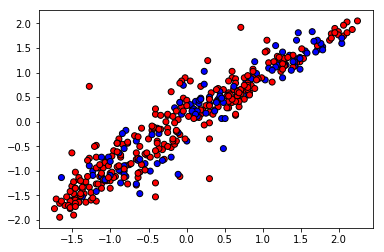

In [24]:
eval_scaler(StandardScaler(), dataset_X, dataset_y)

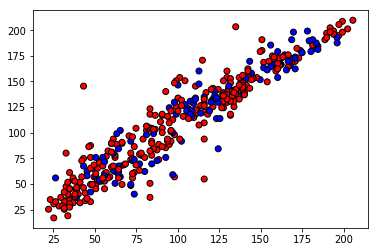

In [25]:
dibuja_dataset(dataset_X, dataset_y)

## Entrena el modelo y evalúa su rendimiento con distintos datasets

Acuerdate de hacer la división de los datos en conjunto de entrenamiento y test, y utilizar una métrica razonable 🧐 de evaluación.

### Dataset original y variable objetivo: gafas/no gafas

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

In [27]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')

In [28]:
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
y_pred = clf.predict(X_test)

In [30]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.95


In [31]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.8529411764705882
Recall: 0.9666666666666667


### Dataset escalado y variable objetivo: gafas/no gafas

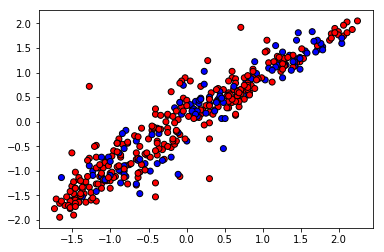

In [32]:
dataset_X_scaled = eval_scaler(StandardScaler(), dataset_X, dataset_y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X_scaled, dataset_y, test_size=.3, random_state=42)

In [34]:
from sklearn.svm import SVC
clf = SVC(C=1, kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [35]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9583333333333334
Precision: 0.8787878787878788
Recall: 0.9666666666666667


#### ¿Se te ocurre alguna manera de mejorar el rendimiento del algoritmo?. 

Puedes probar a evaluar a modificar el parámetro C y ver como se modifican los resultados.

In [36]:
from sklearn.svm import SVC
clf = SVC(C=0.01, kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

### Dataset escalado y variable original: personas

In [37]:
dataset_y = faces.target

In [38]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(dataset_X_scaled, dataset_y, test_size=.3, random_state=42)
clf = SVC(C=0.5, kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [39]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9666666666666667


## ¿Qué conclusiones obtienes?

 Se observa que el escalado del dataset influye de forma importante en los resultados finales, teniendo mejor precisión en los casos que se aplica un escalado de los datos

En este caso, al tener una linearidad y semejanza en los datos y sus niveles, el factor de error no considgue mejorar el ajuste del hiperplano